In [10]:
#Imports
import h5py
import sys
import numpy as np
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.axes import Axes
#import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import csv
from time import time

In [11]:
#Reading data
dir_dataset_sg = 'data/SG24_dataset.h5'
# Open H5 file to read
file = h5py.File(dir_dataset_sg,'r')

X = file['Predictors']
T = file['Target']
U = file['User']

X = np.array(X).transpose() #features
T = np.array(T).transpose() #target
U = np.array(U).transpose() #user
U = U[:,0]
T = T[:,0]

In [12]:
#Make user 8 appear only on the test data

user = 8
ind_all = np.arange(X.shape[0])
ind_all_u = ind_all[U[ind_all]==user]
ind_all = ind_all[U[ind_all]!=user]

ind_train, ind_test = train_test_split(ind_all,
                                       shuffle=True,
                                       stratify=T[ind_all],
                                       test_size=600,
                                       random_state=42)
ind_val, ind_test = train_test_split(ind_test,
                                     shuffle=True,
                                     stratify=T[ind_test],
                                     test_size=240,
                                     random_state=41)

ind_test = np.concatenate((ind_test, ind_all_u))
X_train = X[ind_train,:]
X_val   = X[ind_val,:]
X_test  = X[ind_test,:]
t_train = T[ind_train]
t_val   = T[ind_val]
t_test  = T[ind_test]
u_train = U[ind_train]
u_val   = U[ind_val]
u_test  = U[ind_test]

Accuracy List : [0.9388888888888889, 0.9, 0.9277777777777778, 0.9138888888888889, 0.9222222222222223, 0.9027777777777778, 0.9138888888888889, 0.8916666666666667, 0.8916666666666667]


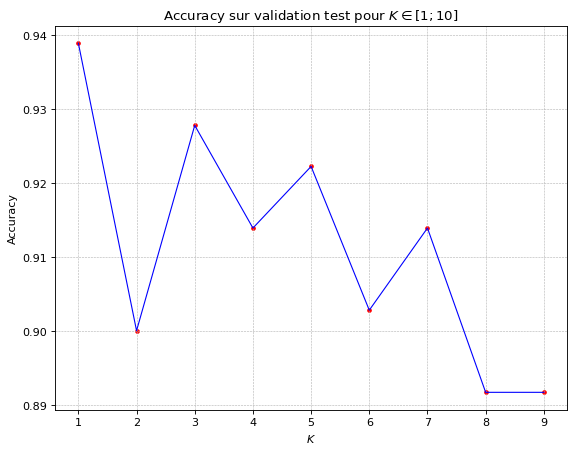

In [13]:
#Find good value for K 
#Let's use the validation set for that
accuracyList = []
KList = range(1,10)
for i in KList:
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, t_train)
    t_pred_val = knn.predict(X_val)
    accuracyList.append(metrics.accuracy_score(t_val, t_pred_val))

print("Accuracy List : "+ str(accuracyList))
# Create a figure of size 8x6 inches, 80 dots per inch
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.grid(linestyle='--', linewidth=0.5)

ax.scatter(KList,accuracyList, s=10, c="red", alpha=1)
ax.plot(KList, accuracyList,color="blue",linewidth=1.0,linestyle="-")
ax.set_title('Accuracy sur validation test pour $K \in [1;10]$')

ax.set_xlabel(r'$K$')
ax.set_ylabel(r'Accuracy')
#plt.show()
fig.savefig('K_Accuracy.png')

In [14]:
#Since we have a good accuracy for K = 3 let's use it fort test
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

t0 = time()
knn.fit(X_train, t_train)
t1 = time()
time_train = t1-t0

t0 = time()
t_pred = knn.predict(X_test)
t1 = time()
time_test= t1-t0

print("Accuracy:",metrics.accuracy_score(t_test, t_pred))
print(classification_report(t_test,t_pred))
#print(confusion_matrix(t_test,t_pred))
print("Time train exec : ",time_train)
print("Time test exec : ",time_test)

Accuracy: 0.8833333333333333
              precision    recall  f1-score   support

           1       0.88      1.00      0.94        15
           2       0.50      0.87      0.63        15
           3       0.94      1.00      0.97        15
           4       1.00      0.80      0.89        15
           5       0.94      1.00      0.97        15
           6       1.00      1.00      1.00        15
           7       1.00      0.67      0.80        15
           8       0.57      0.53      0.55        15
           9       0.88      0.93      0.90        15
          10       1.00      0.93      0.97        15
          11       0.93      0.87      0.90        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      0.87      0.93        15
          16       0.80      0.27      0.40        15
          17       1.00      0.87      0.93        1

In [15]:
#--------------------CROSS VALIDATION-------------------------------

tuned_parameters = [{'kernel': ['rbf'], 'K': list(range(10))}]

scores = ['precision', 'recall']

ind_all = np.arange(X.shape[0])
ind_all_u = ind_all[U[ind_all]==user]
ind_all = ind_all[U[ind_all]!=user]

ind_train, ind_test = train_test_split(ind_all,
                                       shuffle=True,
                                       stratify=T[ind_all],
                                       test_size=600,
                                       random_state=42)

ind_test = np.concatenate((ind_test, ind_all_u))

X_train = X[ind_train,:]
X_test  = X[ind_test,:]
t_train = T[ind_train]
t_test  = T[ind_test]
u_train = U[ind_train]
u_test  = U[ind_test]


In [16]:
from sklearn.model_selection import GridSearchCV#create new a knn model
knn2 = neighbors.KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = [{'n_neighbors': (np.arange(1, 25))}]

t0 = time()
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)#fit model to data
knn_gscv.fit(X, T)
t1 = time()
time_cross_val = t1-t0

#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 3}

In [17]:
"""from sklearn.model_selection import cross_val_score
import numpy as np#create a new KNN model
knn_cv = neighbors.KNeighborsClassifier(n_neighbors=3)#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, T, cv=5)#print each cv score (accuracy) and average them
print(cv_scores)
print("cv_scores mean:{}".format(np.mean(cv_scores)))"""

'from sklearn.model_selection import cross_val_score\nimport numpy as np#create a new KNN model\nknn_cv = neighbors.KNeighborsClassifier(n_neighbors=3)#train model with cv of 5 \ncv_scores = cross_val_score(knn_cv, X, T, cv=5)#print each cv score (accuracy) and average them\nprint(cv_scores)\nprint("cv_scores mean:{}".format(np.mean(cv_scores)))'

In [18]:
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)#knn_gscv.best_params_['n_neighbors'])

t0 = time()
knn3.fit(X_train, t_train)
t1 = time()
time_train_cross_val = t1-t0

X_test_without_user = X_test[u_test!=user]

t0 = time()
t_pred = knn3.predict(X_test_without_user)
t1 = time()
time_test_cross_val = t1 - t0
print("Accuracy:",metrics.accuracy_score(t_test[u_test!=user], t_pred))
print(classification_report(t_test[u_test!=user],t_pred))
print("Time train exec : ",time_train_cross_val)
print("Time test exec : ",time_test_cross_val)
print("Time cross validation exec : ",time_cross_val)

X_test_u = X_test[u_test==user]

t0=time()
t_pred_u = knn3.predict(X_test_u)
t1=time()
time_new_user_pred = t1-t0
print(str("Accuracy for user "+str(user)+" only :"),metrics.accuracy_score(t_test[u_test==user], t_pred_u))
print(classification_report(t_test[u_test==user],t_pred_u))
print("Time new user : ",time_new_user_pred)

Accuracy: 0.9266666666666666
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        25
           2       0.63      0.76      0.69        25
           3       0.92      0.96      0.94        25
           4       0.92      0.92      0.92        25
           5       0.89      1.00      0.94        25
           6       0.96      0.92      0.94        25
           7       1.00      0.96      0.98        25
           8       0.75      0.84      0.79        25
           9       0.92      0.96      0.94        25
          10       1.00      0.92      0.96        25
          11       0.96      0.92      0.94        25
          12       1.00      0.96      0.98        25
          13       0.96      0.96      0.96        25
          14       0.96      1.00      0.98        25
          15       0.96      1.00      0.98        25
          16       0.74      0.56      0.64        25
          17       1.00      0.92      0.96        2

/home/heulin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/heulin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/heulin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
